### Assignment 5: Time series Forecasting using LSTM

In this assignment, we utilize **Apple's (AAPL) stock price data** from **January 1, 2024, to January 1, 2024**, to develop an **LSTM model** aimed at forecasting future closing stock prices. 

**The detail process is described below:** 
1. Data collection
2. Data preprocessing
3. Building LSTM model
4. Training and evaluating the model
5. Predicting and visualization of the result
6. Summary

### 1. Data collection

In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Download historical price data from Yahoo Finance
ticker = "AAPL"  # Apple stock symbol
start_date = "2010-01-01"
end_date = "2024-01-01"
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [18]:
#Display the first few rows of the downloaded data
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440332,6.455078,6.391279,6.422878,493729600
2010-01-05,6.451464,6.487877,6.417458,6.458085,601904800
2010-01-06,6.348848,6.477047,6.342228,6.451467,552160000
2010-01-07,6.337110,6.379844,6.291067,6.372320,477131200
2010-01-08,6.379241,6.379844,6.291369,6.328684,447610800


In [20]:
# Rewrite the column labels of the sample data
df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df.columns]

# Reset the index to make 'Date' a column
df = df.reset_index()

# Display the cleaned DataFrame
print(df.head())

        Date  Close_AAPL  High_AAPL  Low_AAPL  Open_AAPL  Volume_AAPL
0 2010-01-04    6.440332   6.455078  6.391279   6.422878    493729600
1 2010-01-05    6.451464   6.487877  6.417458   6.458085    601904800
2 2010-01-06    6.348848   6.477047  6.342228   6.451467    552160000
3 2010-01-07    6.337110   6.379844  6.291067   6.372320    477131200
4 2010-01-08    6.379241   6.379844  6.291369   6.328684    447610800


**Feature engineering** 

We incorporate several technical indicators—such as **RSI** (a measure of volatility), and **EMAF**, **EMAS**, and **EMAM**—all derived from the stock’s closing and opening prices. Additionally, we create a new target column named **`Target_Next_Close`**, which represents the **closing price of the stock on the following day**, and will be used as the prediction target in our model.

In [22]:
import pandas_ta as ta #include the library for technical indicators
data = df

# Adding indicators
data['RSI']=ta.rsi(data.Close_AAPL, length=20) #Relative strength index (Volatility) (20 days)
data['EMAF']=ta.ema(data.Close_AAPL, length=20) #Exponential moving average - Fast
data['EMAM']=ta.ema(data.Close_AAPL, length=150)#Exponential moving average - Mean
data['EMAS']=ta.ema(data.Close_AAPL, length=150)#Exponential moving average - Slow

data['Target'] = data['Close_AAPL'] - data['Open_AAPL'] # Difference between opening and closing price
data['Target'] = data['Target'].shift(-1) 
data['TargetNextClose'] = data['Close_AAPL'].shift(-1) #Next day closing price
 
data.dropna(inplace=True) #drop empty cells
data.reset_index(inplace = True)
data.drop(['Volume_AAPL', 'Date'], axis=1, inplace=True)

In [24]:
#Display the new columns which are technical indicators 
data.head()

,index,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,RSI,EMAF,EMAM,EMAS,Target,TargetNextClose
0,149,7.827044,7.869176,7.753013,7.817715,52.238658,7.791552,7.136839,7.136839,0.008126,7.876997
1,150,7.876997,7.889035,7.811393,7.868871,53.601778,7.799690,7.146643,7.146643,-0.013241,7.806578
2,151,7.806578,7.837876,7.750603,7.819819,51.423900,7.800346,7.155383,7.155383,-0.156788,7.529119
3,152,7.529119,7.694634,7.517684,7.685907,44.007916,7.774514,7.160334,7.160334,0.153478,7.577267
4,153,7.577267,7.616689,7.406636,7.423789,45.445043,7.755729,7.165856,7.165856,-0.076738,7.496316


In [26]:
import pandas as pd
data_set = data.iloc[:, 1:11] #values
pd.set_option('display.max_columns', None)
data_set.head(5)

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,RSI,EMAF,EMAM,EMAS,Target,TargetNextClose
0,7.827044,7.869176,7.753013,7.817715,52.238658,7.791552,7.136839,7.136839,0.008126,7.876997
1,7.876997,7.889035,7.811393,7.868871,53.601778,7.799690,7.146643,7.146643,-0.013241,7.806578
2,7.806578,7.837876,7.750603,7.819819,51.423900,7.800346,7.155383,7.155383,-0.156788,7.529119
3,7.529119,7.694634,7.517684,7.685907,44.007916,7.774514,7.160334,7.160334,0.153478,7.577267
4,7.577267,7.616689,7.406636,7.423789,45.445043,7.755729,7.165856,7.165856,-0.076738,7.496316


### 2. Data preprocessing 

In this section, we perform **data normalization to a [0, 1] range**, as neural networks require input values to be scaled within this interval for optimal performance and faster convergence.

In [29]:
from sklearn.preprocessing import MinMaxScaler

#Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(data_set) #Take the closing price
print(df_scaled)

[[3.19801369e-03 2.97271622e-03 3.51903264e-03 ... 0.00000000e+00
  4.11151815e-01 3.46132724e-03]
 [3.46132724e-03 3.07662070e-03 3.82835308e-03 ... 5.67950926e-05
  4.09892328e-01 3.09012747e-03]
 [3.09012747e-03 2.80895156e-03 3.50626232e-03 ... 1.07434394e-04
  4.01431024e-01 1.62756319e-03]
 ...
 [9.73486604e-01 9.70199054e-01 9.78037542e-01 ... 9.98048289e-01
  4.49343353e-01 9.74010466e-01]
 [9.74010466e-01 9.68170643e-01 9.68873208e-01 ... 9.99014141e-01
  3.77861062e-01 9.76263645e-01]
 [9.76263645e-01 9.74203697e-01 9.79828178e-01 ... 1.00000000e+00
  3.30401109e-01 9.70761765e-01]]


### 3. Building the LSTM input and LSTM model

In [33]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import numpy as np

#Createing the data for the LSTM input in (samples, time_steps, feautres)
#Split the data into training and testing sets
train_size = int(len(df_scaled)*0.8) #80% training data and rest is test data
train_data, test_data = df_scaled[:train_size], df_scaled[train_size:]

# Define time step (sequence length for LSTM)
back_candles = 30  # Using a fixed time window of back_candles
print(df_scaled.shape[0])

# Function to create sequences for LSTM
def create_sequences(data, back_candles):
    X, y = [], []
    for i in range(len(data) - back_candles):
        X.append(data[i:i+back_candles])  # Selecting `time_steps` previous records
        y.append(data[i+back_candles, -1])    # Target value -> TargetNextClose (Last column)
    return np.array(X), np.array(y).reshape(-1,1)

# Prepare LSTM inputs
X_train, y_train = create_sequences(train_data, back_candles)
X_test, y_test = create_sequences(test_data, back_candles)

print("X_train shape before reshaping:", X_train.shape)
print("y_train shape before reshaping:", y_train.shape)
print("X_test shape before reshaping:", X_test.shape)
print("y_test shape before reshaping:", y_test.shape)

3372
X_train shape before reshaping: (2667, 30, 10)
y_train shape before reshaping: (2667, 1)
X_test shape before reshaping: (645, 30, 10)
y_test shape before reshaping: (645, 1)


**LSTM model architecture is as follows:**

In [36]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, activation=tf.keras.activations.relu, 
               input_shape=(X_train.shape[1], X_train.shape[2]))) #input_shape(time_steps, feautres)
model.add(LSTM(50, return_sequences=True, activation=tf.keras.activations.relu))
model.add(LSTM(50, activation=tf.keras.activations.relu))
model.add(Dense(50, activation=tf.keras.activations.relu))
model.add(Dense(1, activation=tf.keras.activations.relu))

# Print Model Summary
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,201 (215.63 KB)

 Trainable params: 55,201 (215.63 KB)

 Non-trainable params: 0 (0.00 B)

>The inpout data shape is: input_shape(time_steps, feautres) -> 2D
>
>The training data set is 3D: (samples, time_steps, feautres)

### 4. Training and evaluating the model


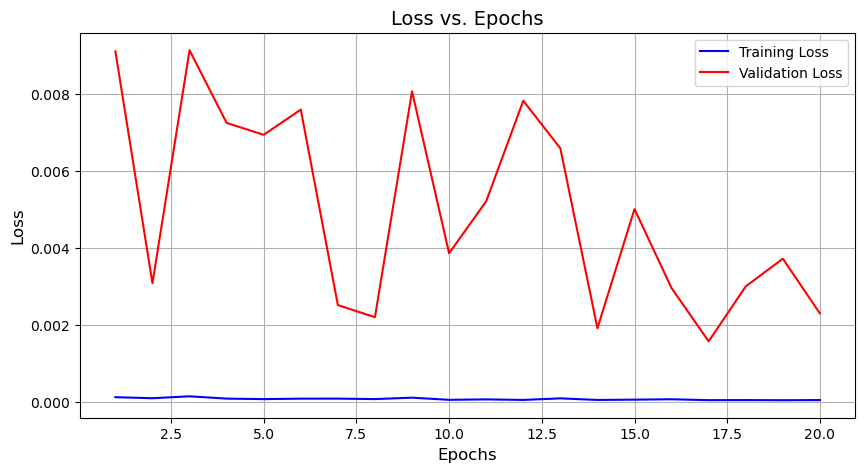

In [45]:
#Compile the model
model.compile(optimizer='adam', loss = 'mean_squared_error')

# Train the model and store history
history = model.fit(X_train, y_train, 
                    epochs=20, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    verbose=0)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history.get('val_loss', None)  # Get validation loss if available
epochs = range(1, len(train_loss) + 1)

# Plot Loss vs. Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss vs. Epochs", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Although the training and validation loss curves may appear not to overlap in the plot, this is primarily due to the **granularity of the y-axis**. In reality, their **numerical values are quite close**, indicating that the model performs consistently across both training and validation datasets.

In [47]:
#Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose = 1)
test_loss = model.evaluate(X_test, y_test, verbose = 1)
print(f"Train Loss: {train_loss: .6f}")
print(f"Test Loss: {test_loss: .6f}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9362e-05
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011    
Train Loss:  0.000048
Test Loss:  0.002305


The magnitudes of both the **training loss** and **testing loss** are very low, which is a positive sign. Additionally, since the values are not significantly different from each other, we can infer that the model is **not overfitting** and is likely generalizing well to unseen data.

### 5. Predicting and the result visualization

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


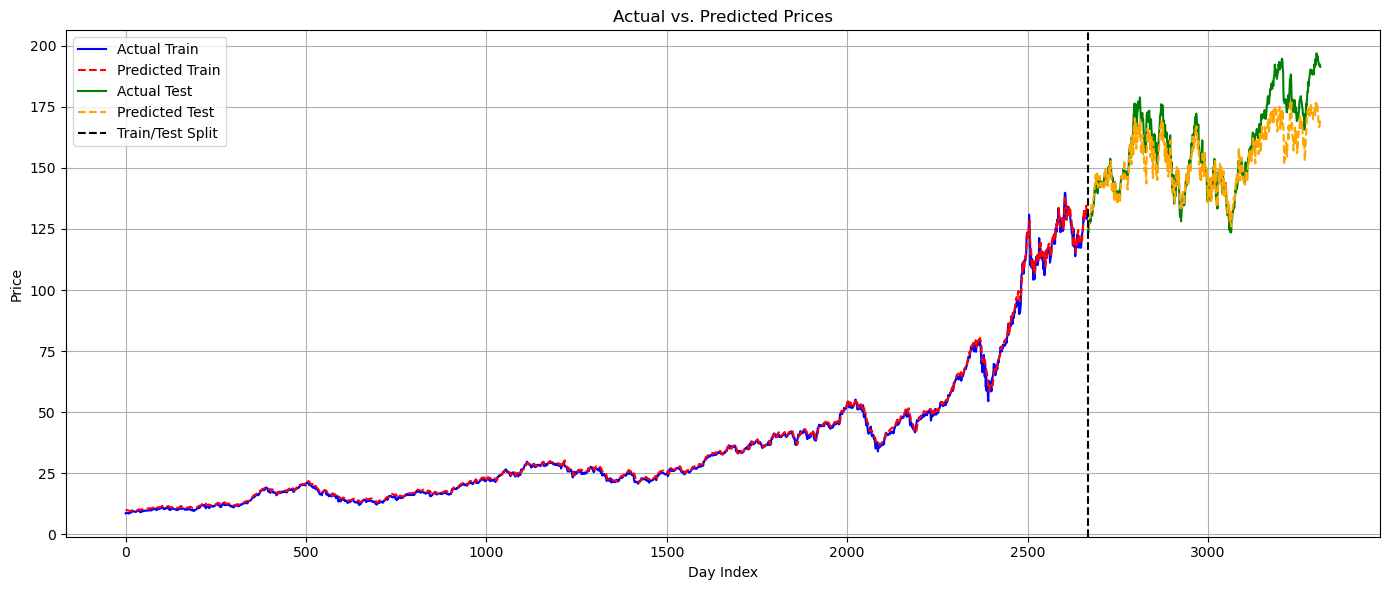

In [60]:
# Total number of features used during scaling
n_features = df_scaled.shape[1]

# Predict the next closing prices
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Helper function to inverse-transform only the target column
def inverse_transform_target_only(preds, target, scaler, n_features, target_index=-1):
    pad = np.zeros((preds.shape[0], n_features))
    pad[:, target_index] = preds.ravel()
    return scaler.inverse_transform(pad)[:, target_index]

# Inverse transform predictions and ground truth
train_predictions_unscaled = inverse_transform_target_only(train_predictions, y_train, scaler, n_features)
y_train_unscaled = inverse_transform_target_only(y_train, y_train, scaler, n_features)

test_predictions_unscaled = inverse_transform_target_only(test_predictions, y_test, scaler, n_features)
y_test_unscaled = inverse_transform_target_only(y_test, y_test, scaler, n_features)

# Plotting
plt.figure(figsize=(14, 6))

train_len = len(y_train_unscaled)

# Plot training predictions
plt.plot(range(train_len), y_train_unscaled, label="Actual Train", color='blue')
plt.plot(range(train_len), train_predictions_unscaled, label="Predicted Train", color='red', linestyle='--')

# Plot testing predictions
plt.plot(range(train_len, train_len + len(y_test_unscaled)), y_test_unscaled, label="Actual Test", color='green')
plt.plot(range(train_len, train_len + len(test_predictions_unscaled)), test_predictions_unscaled, label="Predicted Test", color='orange', linestyle='--')

# Formatting
plt.axvline(x=train_len, color='black', linestyle='--', label='Train/Test Split')
plt.legend()
plt.grid(True)
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Day Index")
plt.ylabel("Price")
plt.tight_layout()
#plt.savefig("data.png")
plt.show()

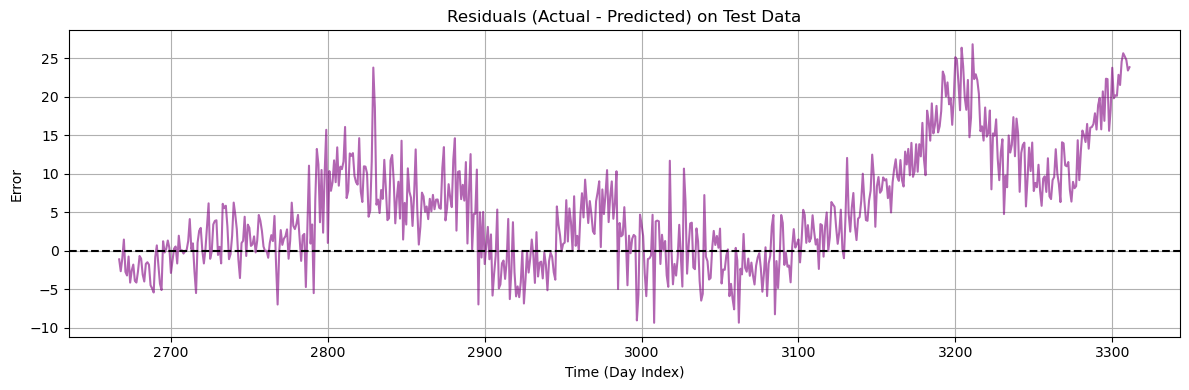

Test MAE: 6.8080
Test RMSE: 9.1080


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Residuals = Actual - Predicted
residuals = y_test_unscaled - test_predictions_unscaled
plt.figure(figsize=(12, 4))
plt.plot(range(train_len, train_len + len(test_predictions_unscaled)), residuals, color='purple', alpha=0.6)
plt.title("Residuals (Actual - Predicted) on Test Data")
plt.xlabel("Time (Day Index)")
plt.ylabel("Error")
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

# MAE
mae = mean_absolute_error(y_test_unscaled, test_predictions_unscaled)
# RMSE
rmse = np.sqrt(mean_squared_error(y_test_unscaled, test_predictions_unscaled))

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

**The MAE tells us that the average stock price the next closing day is around 6.81 USD. While the RMSE tells the predicted value is within  $\pm$ 9.11 USD.**

The resiudal plot clearly model predcitions deviates after 3100 day.


### 6. Summary:
---

The figure above (showing the training and predicted data) illustrates the model's performance on both the training and test datasets. The **blue line** represents the actual training data, while the **red dashed line** shows the model’s predictions on this data. The **green line** depicts the actual test data, and the **yellow dashed line** shows the corresponding model predictions.

The training dataset spans up to approximately day **2700**, after which the test dataset begins. The model demonstrates a **strong fit** on the training data, with the predicted values closely aligning with the actual trend. In the test region, the model continues to **track the actual data well**, although **slight deviations** begin to appear beyond day **3200**.

Overall, the plot **visually confirms the effectiveness of the LSTM model**. The close overlap in the training period, along with consistent alignment in the test phase, indicates that:
- The model has **successfully learned the underlying patterns** in the data.
- It **generalizes effectively** to unseen data, with **no signs of severe overfitting**.

